# Can I find my invoices and contracts?

<u>**NB : All data used in this exercise are fictitious data.**</u>

## Objective:

Each year, the accounting management service is scaning thousands of invoices and contracts. All these pdf scans are stored in a Database, and manually flaged. The accounting service wants to automate the process.

*Given a bunch of documents without label are you able to separate invoices from contracts?*

As a Data Scientist you offer to implement a machine learning solution. Nonetheless, accounting services bring to your attention:
 - Formats are constantly evolving therefore, you cannot use past documents to design your solution
 - They will send you TEXT data after passing pdf into an OCR (noise may happen)
 
## More Technically
 - **/train** folder contains raw text invoices and contracts (0000.txt to 1999.txt)
 - **/val** folder contains raw text invoices and contracts (0000.txt to 1999.txt) and *label.csv* to evaluate performances.
 
You are asked to:
 - Build a machine learning process to seperate invoices from contracts without previous knowledge.
 - Evaluate the performances on the validation (/val) dataset.
 
*Feel free to import any usual python and ML packages.*

# Introduction

Ma solution pour le challenge est d'utiliser la méthodologie suivante. D'abord travailler les données des fichiers texte (data mining), puis de structurer les données dans des dataframes en étudiant la fréquence des mots. Enfin, j'utilise un algorithme non supervisés de clusterisation : le K-means.  

Pour gagner du temps, j'ai sauvegardé les dataframes les plus longs à calculer dans des fichiers csv, fournis avec ce notebook.
Bien qu'ayant réduit les calculs, chaque texte demande à peu près 1 seconde de process. Cumulés le temps de travail peut être de 30 minutes pour chaque dataframe.  

Enfin, pour résoudre ce problème, j'ai suivi le sommaire suivant:

# Sommaire 

1. Nettoyer les données 
    - Récupérer les textes
    - Traitement NLP
  
    
2. Structurer les données  
    - Récupérer la fréquences des mots avec la méthode de TD-IDF
    - Sélection des mots les plus fréquents et suscptibles de reconnaitre le type du document
    - Création d'une structure de dataframe 
  
3. Clusteriser les données  
    - Vérification du nombre de cluster
    - Application du modèle K-Means
   
4. Application sur le dossier de validation

# Source

<u>*NLP : *</u> 
  
Traitement Automatique du Langage Naturel en français (TAL / NLP). (2019). Retrieved 28 January 2022, from https://www.stat4decision.com/fr/traitement-langage-naturel-francais-tal-nlp/  
  
<u>*TD-IDF*</u>  
  
Vieille, M. (2021). NLP : Natural Language Processing - Lovely Analytics. Retrieved 28 January 2022, from https://www.lovelyanalytics.com/2021/03/19/nlp-natural-language-processing/    
  
Synthèse extractive de texte à l'aide de spaCy en Python. (2022). Retrieved 28 January 2022, from https://ichi.pro/fr/synthese-extractive-de-texte-a-l-aide-de-spacy-en-python-150270551129495
  
<u>*Clustering*</u>   
  
pythondatascientist/06_02_Machine_learning_non_supervise.ipynb at master · pierrelouisIV/pythondatascientist. (2022). Retrieved 28 January 2022, from https://github.com/pierrelouisIV/pythondatascientist/blob/master/notebooks/06_02_Machine_learning_non_supervise.ipynb

In [38]:
import pandas as pd
import numpy as np
import pathlib
import random
import spacy

from pathlib import Path # pour le chemin du fichier
from autocorrect import Speller
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

nlp = spacy.load("fr_core_news_sm")

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

### Charger les fichiers

In [39]:
def getTextOfFile(fileName):
    '''
    Entrée : [string] , nom du fichier
    Sortie : [string] , texte du fichier
    '''
    filePath = 'train/' + fileName
    file = Path.cwd() / filePath

    # Open the file in "read" mode ('r') 
    with open(file, 'r') as text:
        textfile = text.read()
    return textfile

In [40]:
fileTrainNameList = []

for path in pathlib.Path("./train").iterdir():
    if path.is_file():
        fileTrainNameList.append(path.name)

# Extraire et nettoyer les données  
## Récupérer un fichier, miner les mots (Natural Language Processing)

- Tokeniser le texte 
- Nettoyer le texte (retirer mots courants, ponctuations, mot de plus de 3 caractères)
- Récupérer la racine des mots restants (stemming)

### Fonction pour Tokeniser le texte

In [41]:
def return_token(sentence):
    doc = nlp(sentence)
    
    return [X.text for X in doc]

### Fonction pour nettoyer le texte


In [42]:
def getCleanText(text):
    stopChar = ["\n","©","Ã","*",":","\n\n",":",",",".",";","(",")","l'",'"',"d'",'a',"rã","sit"," "]
    stopWords = set(stopwords.words('french'))
    clean_words = []
    spell = Speller(lang='fr')
    
    for token in text:
        if token not in stopWords :
            # if token not in stopChar and token not in punctuation and len(token)>3:
            if len(token)>3:
                # token = spell(token)
                clean_words.append(token)
    return clean_words

### Fonction pour récupérer la racine des mots 

In [43]:
stemmer = SnowballStemmer(language='french')

def getStemWord(text):
    #retourner les mots en stemming
    #retourne juste la racine des mots
    stemWord = []
    
    for token in text:
        stemWord.append( stemmer.stem(token))
        
    return stemWord

### Fonction finale de preprocess NLP : 

In [44]:
def getTextFinal(fileName):
   
    textbrut = getTextOfFile(fileName)
    textToken = return_token(textbrut)
    cleanText = getCleanText(textToken)
    stemText = getStemWord(cleanText)    
    return stemText

## Récupérer des récurences de mots

On utilise la pondération tf-idf des mots dans le texte.    
Le **TD-IDF** (TF (Term Frequency) et IDF (Inverse Document Frequency)) est une méthode de pondération souvent utilisée en recherche d'information et en particulier dans la fouille de textes.  
  
Cette mesure statistique permet d'évaluer l'importance d'un terme contenu dans un document.  

Dans notre cas, on recherche dans chaque texte la fréquence de chaque mots. Le poids du mot augmente proportionnellement au nombre d'occurrences du mot dans le document.  
  
On ne retient que les mots dont le poids est supérieur à 0.076923.(valeur arbitraire)

In [45]:
def getFreqWord(text):
   
    freq_word = Counter(text)  #frequence des mots
 
    max_freq = Counter(text).most_common(1)[0][1]   #frequence max 
   
    freqText = Counter() #variable de retour
    
    #pour chaque mot trouver son poids id-idf(si supérieur on le garde)
    for w in freq_word:
        if (freq_word[w]/max_freq) >= 0.076923:
            freqText[w] = (freq_word[w]/max_freq)
    return freqText

# Structurer les données     

- On ajoute le poids de tout les mots les plus fréquents dans les textes

In [46]:
def addFreqDoc(df,text):
    freqText = getFreqWord(text)

    for word in freqText:
        if word  in freqText.keys():
            if word not in list(df['word']):
                df = df.append({'word': word,'freq':freqText[word]}, ignore_index=True)
            else:
                df.loc[df.word==word,'freq'] +=   freqText[word]   
    return df

## Création d'un dataframe des mots les plus courants
     
df_freq est un dataframe avec le mot et la fréquence générale du mot dans les textes  

In [47]:
# 35 minutes pour 2000 fichiers, les valeurs peuvent etre trouvé dans "freq_word.csv" 
def getDataframeFrequenceGlobale(fileNameList):
    df_freq = pd.DataFrame(columns=['word', 'freq'])
    for i in range(len(fileNameList)):
       
        text = getTextFinal(fileNameList[i]) # extraire le texte du fichier
        df_freq = addFreqDoc(df_freq,text)  # ajouter au df la fréquence des mots du fichier courant
        
    return df_freq

# méthode plus rapide : séléctionner des fichiers au hasard et réduire la taille de la boucle 
def getDataframeFrequenceGlobaleRandom(fileNameList):

    df_freq = pd.DataFrame(columns=['word', 'freq'])
    for i in range(300):
        # sélectionner un fichier au hasard
        docRandom = random.randint(0,1999)
        
        text = getTextFinal(fileNameList[docRandom]) # extraire le texte du fichier
        df_freq = addFreqDoc(df_freq,text)  # ajouter au df la fréquence des mots du fichier courant
    
    return df_freq


### 3 possibilités pour récupérer les fréquences globales:
- Utiliser *getDataframeFrequenceGlobale* pour avoir celle de tout les fichiers
- Utiliser *getDataframeFrequenceGlobaleRandom* et choisir le nombre de fichiers choisi aléatoirement
- Utiliser un csv déjà prêt (enregistré à partir de la méthode 1)

In [48]:
# df_freq_train = getDataframeFrequenceGlobale(fileTrainNameList)

# df_freq_train = getDataframeFrequenceGlobaleRandom(fileTrainNameList)

df_freq_train = pd.read_csv("freq_word.csv")  

### Data cleaning des fréquences

In [49]:
#Trier par ordre croissant les valeurs de fréquence
df_freq_train = df_freq_train.sort_values(by='freq',ascending=False)
#On retire les 15 premiers qui sont trop en communs entre les deux types
df_freq_train = df_freq_train.drop([0, 15]) 
#On récupère les 50 premières
df_freq_train = df_freq_train.head(50)
#Les mots les plus fréquents sont les colonnes du df de notre modèle
nameColumn = df_freq_train.head(50)['word']

### Création d'un dataframe du dossier train  


     
Le dataframe du dossier du train a pour:  
-   colonne : les mots les plus fréquents trouvés par le dataframe de fréquence
-   ligne  : chaque texte et ses fréquences sur les mots sélectionés

In [50]:
#créationn du dataframe du modèle, l'index est le nom des fichiers
df_train = pd.DataFrame(columns=nameColumn)
#Ajout du nom des fichier
df_train["file"] = fileTrainNameList

### Remplir le dataframe du dossier train

In [51]:
# 33minutes pour 2000 fichiers
def fillDataframe(df):
    for i in range(len(df.index)):
        print(df['file'].iloc[i])
        file = df['file'].iloc[i]
        text = getTextFinal(file) # extraire le texte du fichier
        freq = getFreqWord(text)
        for column in df.columns:
            for word in freq:
                if column == word:
                    df[word].iloc[i]= freq[word]
    # Remplacer les valeurs nan en 0                
    df = df.fillna(0)
    
    # Faculatif déplacer la colonne file à gauche
    # df.insert(0, "file", df.pop("file")) 
    return df

2 méthodes : 
- Utiliser la fonction *fillDataframe* pour remplir le dataframe de train
- Utiliser le csv *dataset_train_final* déjà rempli avec la méthode 1

In [52]:
# df_train = fillDataframe(df_train)

df_train = pd.read_csv("dataset_train_final.csv")  
df_train =df_train.drop('Unnamed: 0',axis=1)

# Clusteriser les données 
  
Les k-means (k-moyennes) sont  un algorithme d’apprentissage non supervisé permettant de construire des classes d’observations à partir d’un jeu de données de grande dimension.   
  
Étant donnés des points et un entier k, le problème est de diviser les points en k groupes, souvent appelés clusters, de façon à minimiser une certaine fonction.

## Trouver le nombre de cluster

L'inertie représente la somme des carrés des distances des échantillons à leur centre de cluster le plus proche, pondérée par les poids des échantillons s'ils sont fournis.

En calculant l'inertie avec chaque k entre 2 et 9, on peut trouver quel k correspond le plus à notre problème.

In [53]:
def clusteringData(df):
    x=df.select_dtypes(np.number)

    # on crée une liste dans laquelle on stocke les inerties
    inerties=[]
    # on fait une boucle de 2 à 9 pour tester toutes ces possibiliéts
    for k in range(2, 10):
        # pour chaque k, on crée un modèle et on l’ajuste
        kmeans=KMeans(n_clusters=k)
        kmeans.fit(x)
        # on stocke l’inertie associée
        inerties.append(kmeans.inertia_)
        
    # on représente le graphique
    fig=plt.figure(figsize=(10, 5))
    plt.plot(range(2, 10), inerties)
    plt.xlabel("Nombre de clusters")
    plt.ylabel("Inertie")
    plt.title('Inertie vs nombre de classes')

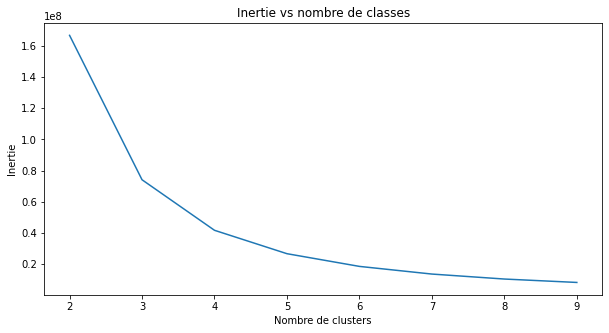

In [54]:
clusteringData(df_train)

On remarque que le nombre de cluster idéal est 2.  
Cela correspond avec l'exercice qui cherche à distinguer contrats et factures.  


## Application du modèle

  
On applique le modèle avec 2 clusters.
   
*getClasses retourne un array avec le numero du cluster 

In [55]:
def getClasses(df):
    x=df.select_dtypes(np.number)
    modele_km=KMeans(n_clusters=2)
    modele_km.fit(x)
    # on stocke les classes d’appartenance dans classes
    classes=modele_km.labels_
    return classes

Pour interpreter les résultatss, on assoscie dans un nouveau dataframe, le fichier texte et son type.

In [56]:
classes = getClasses(df_train)

df_resulat_train = pd.DataFrame()
df_resulat_train["file"] = fileTrainNameList
df_resulat_train["classe"] = classes
df_resulat_train["classe"] = df_resulat_train["classe"].replace(0,"Contrat")
df_resulat_train["classe"] = df_resulat_train["classe"].replace(1,"Facture")

## Résultat du modèle pour le dossier train

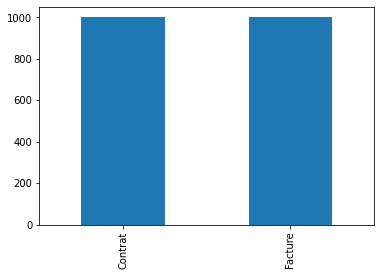

In [57]:
df_resulat_train['classe'].value_counts().plot(kind='bar');

# Application sur le dossier val

    
Nous utilisons les mêmes colonnes que pour le dossier train. Les mots fréquents seront donc les mêmes.  


## Récupérer le nom des fichiers texte et créer un dataframe de validation

In [58]:
fileValNameList = []

for path in pathlib.Path("./val").iterdir():
    if path.is_file():
        fileValNameList.append(path.name)
        
df_val = pd.DataFrame(columns=nameColumn)
df_val["file"] = fileTrainNameList

2 solutions pour remplir le dataframe de validation : 
- Utiliser la fonction *fillDataFrame* (environ 30 minutes, 1sec/fichier)
- Charger le csv déjà rempli avec la méthode 1

In [59]:
# df_val = fillDataframe(df_val)

df_val = pd.read_csv("dataset_val_final.csv")
# df_val = df_val.drop([0, 15],axis=1)  

## Clusteriser les données de validation

Utilisation du modèle de clustering K-means pour déterminer le label du fichier

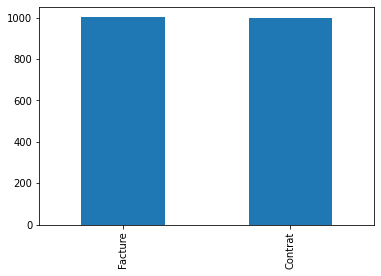

In [60]:
classes = getClasses(df_val)

df_resulat_val = pd.DataFrame()
df_resulat_val["file"] = fileTrainNameList
df_resulat_val["classe"] = classes
df_resulat_val["classe"] = df_resulat_val["classe"].replace(0,"Contrat")
df_resulat_val["classe"] = df_resulat_val["classe"].replace(1,"Facture")

df_resulat_val.head()
df_resulat_val['classe'].value_counts().plot(kind='bar');

Toujours 2 clusters égaux, c'est bon signe.

## Comparaison des résulats avec la solution fournie

On charge les données de validation dans un dataframe que l'on concatène avec nos résultats

In [61]:
df_verification_val = pd.read_csv("label.csv")
df_verification_val = pd.concat([df_verification_val, df_resulat_val], axis = 1)

### Fonction de vérifation

In [62]:
def checkResult(df):
    error = 0
    #incrémenter l'erreur si le fichier n'est pas bien reconnu
    for i in range(len(df.index)):
        if df['label'].iloc[i] !=df['classe'].iloc[i]:
            error+=1
    return error * 100 / len(df.index) #retourne un pourcentage

### Résultat de la modélisation

In [63]:
result= checkResult(df_verification_val)
print("Le résulat est de : ",result,"%")

Le résulat est de :  100.0 %
